In [66]:
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from transformers import ElectraTokenizer, ElectraModel, AutoModel, AutoTokenizer, BertModel, AlbertTokenizer, AlbertModel
from kobert_tokenizer import KoBERTTokenizer
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [67]:
device = torch.device("mps")

In [68]:
#hyperpram

max_len = 64
batch_size = 32
warmup_ratio = 0.1
num_epochs = 9
max_grad_norm = 1
learning_rate =  5e-5

In [69]:
# load data

data = pd.read_csv('/Users/dhewl/Desktop/han-star/data/data.csv')
data_list = data.apply(lambda row: [row['story'], row[1:].tolist()], axis=1)
dataset_train, dataset_test = train_test_split(data_list, test_size=0.1, random_state=42)

class Dataset(Dataset):
    def __init__(self, dataset, tokenizer):
        self.encodings = tokenizer([enc[0] for enc in dataset], truncation=True, padding=True)
        self.labels = [label[1] for label in dataset]

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [70]:
#acc, f1 func

def accuracy(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred > 0.5, dtype=float)
    acc_list = []
    for cate in range(y_pred.shape[1]):
        acc_list.append(accuracy_score(y_true[:, cate], y_pred[:, cate]))
    return sum(acc_list) / len(acc_list)

def get_f1_score(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred > 0.5, dtype=float)
    return f1_score(y_true, y_pred, average='micro')

In [78]:
# train func
import matplotlib.pyplot as plt

def train_model(model, model_name, train_dataloader, test_dataloader):
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]

    optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)

    pos_weight = torch.ones(10).to(device) * 9
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    t_total = len(train_dataloader) * num_epochs
    warmup_step = int(t_total * warmup_ratio)
    scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

    train_history = {'accuracy': [], 'f1_score': []}
    test_history = {'accuracy': [], 'f1_score': []}
    loss_history = []

    for e in range(num_epochs):
        model.train()
        for batch_id, batch_data in enumerate(train_dataloader):
            input_ids = batch_data['input_ids'].to(device)
            attention_mask = batch_data['attention_mask'].to(device)
            token_type_ids = batch_data['token_type_ids'].to(device)
            labels = batch_data['labels'].float().to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask, token_type_ids)

            loss = loss_fn(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
            optimizer.step()
            scheduler.step()

            sigmoid = nn.Sigmoid()
            y_pred = sigmoid(outputs).cpu().detach().numpy()
            train_acc = accuracy(labels.cpu().detach().numpy(), y_pred)
            train_f1 = get_f1_score(labels.cpu().detach().numpy(), y_pred)

            print(f"[Train] Epoch {e+1}, Batch {batch_id+1}, Loss: {loss.item()}, Acc: {train_acc}, F1: {train_f1}")

            train_history['accuracy'].append(train_acc)
            train_history['f1_score'].append(train_f1)
            loss_history.append(loss.item())
        # 평가 루프
        model.eval()
        num_break = 0
        with torch.no_grad():
            for batch_id, batch_data in enumerate(test_dataloader):
                input_ids = batch_data['input_ids'].to(device)
                attention_mask = batch_data['attention_mask'].to(device)
                token_type_ids = batch_data['token_type_ids'].to(device)
                labels = batch_data['labels'].float().to(device)

                outputs = model(input_ids, attention_mask, token_type_ids)
                test_acc = accuracy(labels.cpu().detach().numpy(), sigmoid(outputs).cpu().detach().numpy())
                test_f1 = get_f1_score(labels.cpu().detach().numpy(), sigmoid(outputs).cpu().detach().numpy())
                if test_acc == 1 and test_f1 == 1:
                    num_break += 1
                print(f"[Test] Epoch {e+1}, Batch {batch_id+1}, Acc: {test_acc}, F1: {test_f1}")
                test_history['accuracy'].append(test_acc)
                test_history['f1_score'].append(test_f1)
        torch.save(model.state_dict(), f'/Users/dhewl/Desktop/han-star/model/{model_name}:{e}:{test_acc}:{test_f1}.pt')
        if num_break > 20:
            break
            

    fig, ax = plt.subplots(figsize=(5, 2.7))
    ax.plot(np.arange(len(train_history['accuracy'])), train_history['accuracy'], label='Train Accuracy')
    ax.plot(np.arange(len(train_history['f1_score'])), train_history['f1_score'], label='Train F1 Score')
    ax.plot(np.arange(len(loss_history)), loss_history, label='Loss')
    ax.legend()
    plt.show()

In [72]:
#KoELECTRA
KoELECTRAtokenizer = ElectraTokenizer.from_pretrained('monologg/koelectra-base-v3-discriminator')
KoELECTRAModel = ElectraModel.from_pretrained('monologg/koelectra-base-v3-discriminator', return_dict=False)

def get_KoELECTRA_data():
    data_train = Dataset(dataset_train, KoELECTRAtokenizer)
    data_test = Dataset(dataset_test, KoELECTRAtokenizer)
    train_dataloader = DataLoader(data_train, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(data_test, batch_size=batch_size, shuffle=False)

    return train_dataloader, test_dataloader

class KoELECTRAClassifier(nn.Module):
    def __init__(self, electra, hidden_size=768, num_classes=10, dr_rate=None):
        super(KoELECTRAClassifier, self).__init__()
        self.electra = electra
        self.dr_rate = dr_rate
        self.classifier = nn.Linear(hidden_size, num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)

    def forward(self, token_ids, attention_mask, segment_ids):
        out = self.electra(
            input_ids=token_ids,
            attention_mask=attention_mask,
            token_type_ids=segment_ids.long()
        )
        out = out[0][:, 0, :]
        if self.dr_rate:
            out = self.dropout(out)
        return self.classifier(out)

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[Train] Epoch 1, Batch 1, Loss: 1.4317169189453125, Acc: 0.54375, F1: 0.1511627906976744
[Train] Epoch 1, Batch 2, Loss: 1.331895112991333, Acc: 0.55, F1: 0.13253012048192772
[Train] Epoch 1, Batch 3, Loss: 1.2833503484725952, Acc: 0.590625, F1: 0.19631901840490798
[Train] Epoch 1, Batch 4, Loss: 1.4338037967681885, Acc: 0.53125, F1: 0.18478260869565216
[Train] Epoch 1, Batch 5, Loss: 1.3933504819869995, Acc: 0.50625, F1: 0.19387755102040816
[Train] Epoch 1, Batch 6, Loss: 1.3696184158325195, Acc: 0.528125, F1: 0.1564245810055866
[Train] Epoch 1, Batch 7, Loss: 1.3808437585830688, Acc: 0.534375, F1: 0.1945945945945946
[Train] Epoch 1, Batch 8, Loss: 1.4999061822891235, Acc: 0.49375, F1: 0.15625
[Train] Epoch 1, Batch 9, Loss: 1.3628309965133667, Acc: 0.515625, F1: 0.16216216216216217
[Train] Epoch 1, Batch 10, Loss: 1.3224653005599976, Acc: 0.528125, F1: 0.233502538071066
[Train] Epoch 1, Batch 11, Loss: 1.4255287647247314, Acc: 0.521875, F1: 0.20725388601036268
[Train] Epoch 1, Batch 

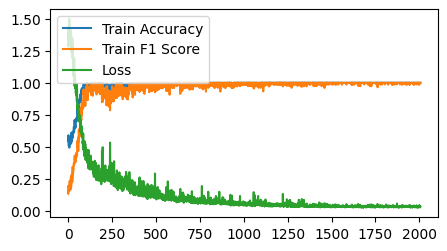

In [79]:
#KoELECTRA train
import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'
model = KoELECTRAClassifier(KoELECTRAModel, dr_rate=0.5).to(device)
train_dataloader, test_dataloader = get_KoELECTRA_data()
train_model(model, 'KoELECTRA', train_dataloader, test_dataloader)